In [1]:
!pwd

/home/evanlee/Pancreas_AD2


In [2]:
from ADlasso2 import AD2_w_utils as ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import scipy
import sklearn
import copy
import importlib


In [3]:
import scanpy as sc
import scvelo as scv

# data = scv.datasets.pancreas(file_path='/Users/evanli/Documents/Research_datasets/endocrinogenesis_day15.h5ad')
data = scv.datasets.pancreas(file_path='/home/evanlee/Pancreas_AD2/endocrinogenesis_day15.h5ad')
label = data.obs['clusters'].tolist()
# Log normalize
sc.pp.log1p(data)

In [4]:
data.shape

(3696, 27998)

In [41]:
celltype = 'Alpha'
fdf = pd.read_csv(f'./Pancreas_result/{celltype}/{celltype}_features.txt', sep='\t', header=None, names=['Gene', 'Weight', 'Tendency'])
fdf.head()

,Gene,Weight,Tendency
0,Rpl7,-0.109454,0
1,Sf3b1,-0.024479,0
2,Aamp,0.014371,1
3,Cryba2,-0.117479,0
4,Resp18,0.056131,1


## Read in the ADlasso features from 8 cell types

In [5]:
types = ['Beta', 'Delta', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Ductal', 'Epsilon', 'Alpha']
types = sorted(types)

all_features = {}
positive_features = {}
for celltype in types:
    print('Reading:', celltype)
    # all features (including positive and negative)
    features_df = pd.read_csv(f'./Pancreas_result/{celltype}/{celltype}_features.txt', sep='\t', header=None, names=['Gene', 'Weight', 'Tendency'])
    all_features[celltype] = features_df['Gene'].tolist()
    # positive features
    positive_features_df = features_df[features_df['Tendency'] == 1]
    positive_features[celltype] = positive_features_df['Gene'].tolist()


Reading: Alpha
Reading: Beta
Reading: Delta
Reading: Ductal
Reading: Epsilon
Reading: Ngn3 high EP
Reading: Ngn3 low EP
Reading: Pre-endocrine


In [6]:
for celltype in all_features.keys():
    print(celltype, len(all_features[celltype]))
print('=====')
for celltype in positive_features.keys():
    print(celltype, len(positive_features[celltype]))

Alpha 488
Beta 150
Delta 45
Ductal 442
Epsilon 57
Ngn3 high EP 161
Ngn3 low EP 873
Pre-endocrine 222
=====
Alpha 211
Beta 80
Delta 14
Ductal 252
Epsilon 20
Ngn3 high EP 67
Ngn3 low EP 566
Pre-endocrine 90


In [7]:
# add the features from 8 cell types into a single list
all_features_list = [g for g_celltype in all_features.values() for g in g_celltype]
positive_features_list = [g for g_celltype in positive_features.values() for g in g_celltype]
print(len(all_features_list))
print(len(positive_features_list))

2438
1300


In [8]:
data.shape

(3696, 27998)

## Plot Leiden UMAP with HVG2000

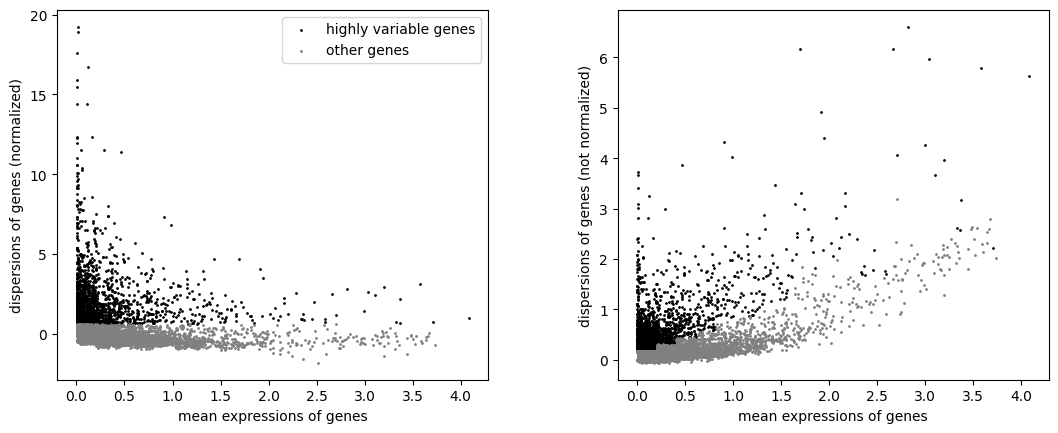

In [9]:
# select HVG2000 (from original 27998 genes)
sc.pp.highly_variable_genes(data, n_top_genes=2000)
sc.pl.highly_variable_genes(data)


In [10]:
# 2000 HVGs
sum(data.var['highly_variable'])

2000

In [11]:
# filtering the non-Highly variable genes in data
data_HVG = data[:, data.var.highly_variable]  # choose columns, Genes
data_HVG.shape  # (3696, 2000)

(3696, 2000)

In [12]:
id(data)

140075747804832

In [13]:
id(data_HVG)

140075533751776

In [14]:
data_HVG.obs

,clusters_coarse,clusters,S_score,G2M_score
index,,,,
AAACCTGAGAGGGATA,Pre-endocrine,Pre-endocrine,-0.224902,-0.252071
AAACCTGAGCCTTGAT,Ductal,Ductal,-0.014707,-0.232610
AAACCTGAGGCAATTA,Endocrine,Alpha,-0.171255,-0.286834
AAACCTGCATCATCCC,Ductal,Ductal,0.599244,0.191243
AAACCTGGTAAGTGGC,Ngn3 high EP,Ngn3 high EP,-0.179981,-0.126030
...,...,...,...,...
TTTGTCAAGTGACATA,Pre-endocrine,Pre-endocrine,-0.235896,-0.266101
TTTGTCAAGTGTGGCA,Ngn3 high EP,Ngn3 high EP,0.279374,-0.204047
TTTGTCAGTTGTTTGG,Ductal,Ductal,-0.045692,-0.208907


In [15]:
# PCA
sc.tl.pca(data_HVG, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(data_HVG, n_neighbors=15)

# kNN
# sc.external.pp.bbknn(data_HVG)

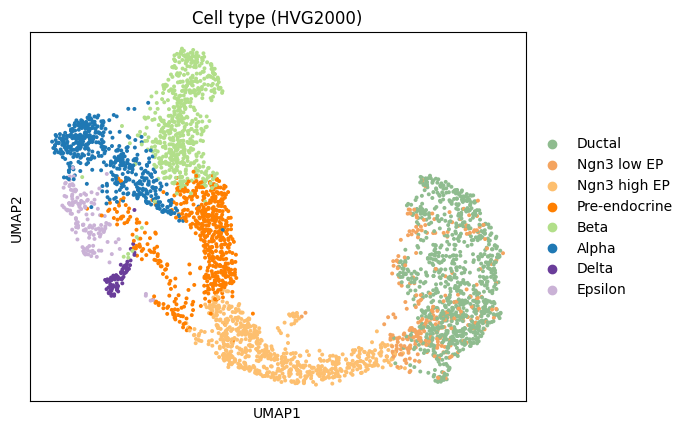

In [42]:
# UMAP
sc.tl.umap(data_HVG)
sc.pl.umap(data_HVG, color='clusters', title='Cell type (HVG2000)')

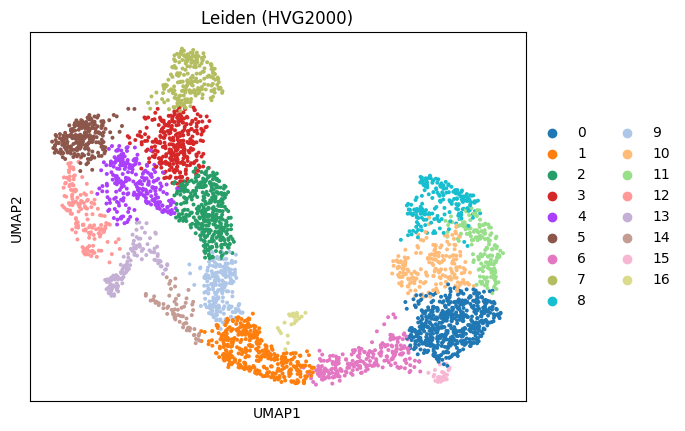

In [43]:
# Leiden clustering
sc.tl.leiden(data_HVG)

# Plot Leiden UMAP
sc.pl.umap(data_HVG, color='leiden', title='Leiden (HVG2000)')

## Plot Leiden UMAP with all ADlasso features

In [18]:
data_all_features = data[:, all_features_list]
data_all_features.shape

(3696, 2438)

In [19]:
id(data_all_features)

140084722063008

In [20]:
# PCA
sc.tl.pca(data_all_features, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(data_all_features, n_neighbors=15)

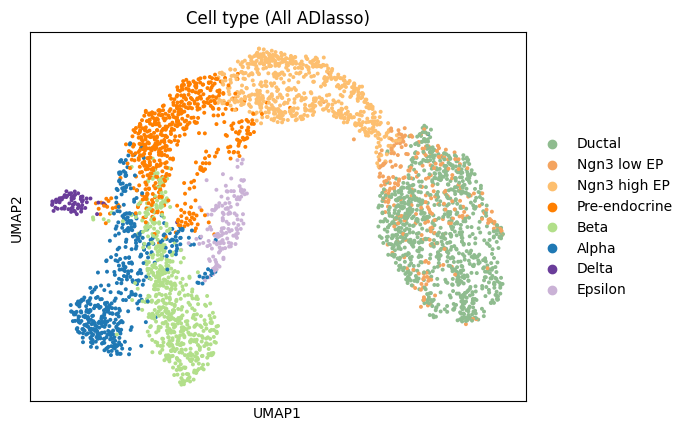

In [44]:
# UMAP
sc.tl.umap(data_all_features)
sc.pl.umap(data_all_features, color='clusters', title='Cell type (All ADlasso)')

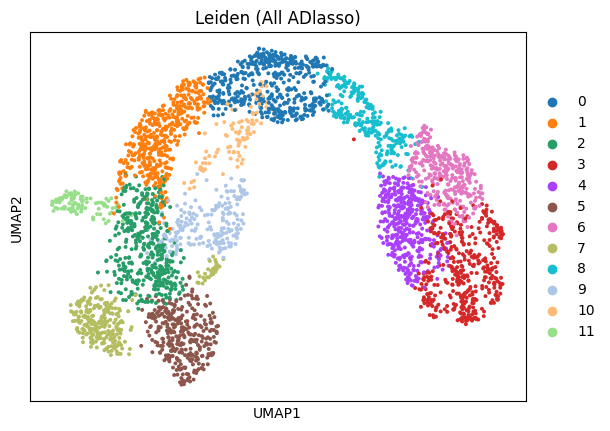

In [45]:
# Leiden clustering
sc.tl.leiden(data_all_features)

# Plot Leiden UMAP
sc.pl.umap(data_all_features, color='leiden', title='Leiden (All ADlasso)')

## Plot Leiden UMAP with positive ADlasso features

In [28]:
data_positive = data[:, positive_features_list]
data_positive.shape

(3696, 1300)

In [29]:
id(data_positive)

140075465408224

In [30]:
# PCA
sc.tl.pca(data_positive, svd_solver='arpack')

# neighborhood graph
sc.pp.neighbors(data_positive, n_neighbors=15)

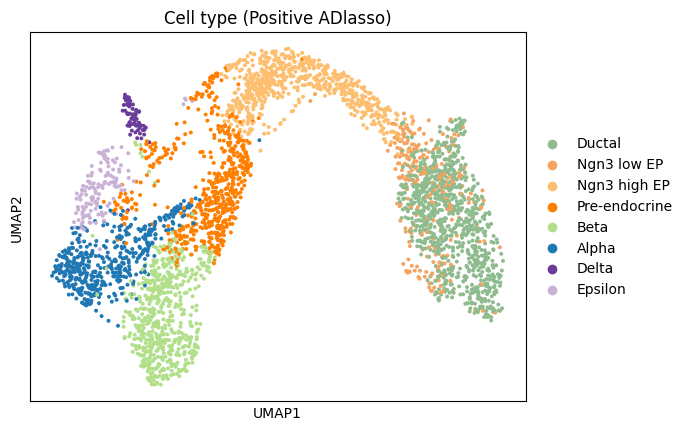

In [46]:
# UMAP
sc.tl.umap(data_positive)
sc.pl.umap(data_positive, color='clusters', title='Cell type (Positive ADlasso)')

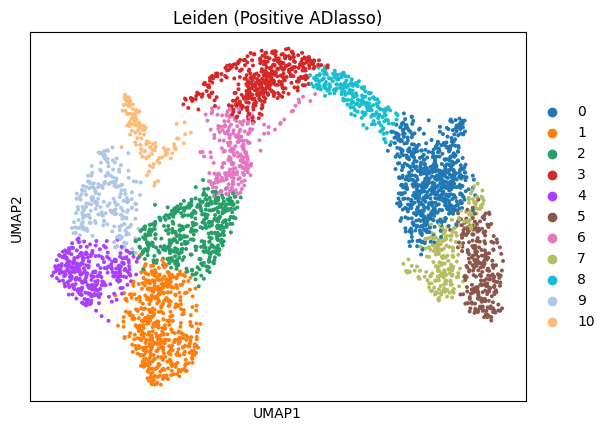

In [48]:
# Leiden clustering
sc.tl.leiden(data_positive)

# Plot Leiden UMAP
sc.pl.umap(data_positive, color='leiden', title='Leiden (Positive ADlasso)')

## Evaluate ARI

In [23]:
import sklearn
from sklearn.metrics.cluster import adjusted_rand_score



In [24]:
celltypes = np.unique(label)
type2num = {ct: idx for idx, ct in enumerate(celltypes)}

In [25]:
type2num

{'Alpha': 0,
 'Beta': 1,
 'Delta': 2,
 'Ductal': 3,
 'Epsilon': 4,
 'Ngn3 high EP': 5,
 'Ngn3 low EP': 6,
 'Pre-endocrine': 7}

In [26]:
# ARI for HVG2000: Leiden vs. Actual celltype
labels_true = [type2num[ct] for ct in label]
labels_pred = data_HVG.obs['leiden'].tolist()
adjusted_rand_score(labels_true, labels_pred)

0.4355415335576269

In [27]:
# ARI for all ADlasso features
labels_true = [type2num[ct] for ct in label]
labels_pred = data_all_features.obs['leiden'].tolist()
adjusted_rand_score(labels_true, labels_pred)

0.44895556894098926

In [33]:
# ARI for all ADlasso features
labels_true = [type2num[ct] for ct in label]
labels_pred = data_positive.obs['leiden'].tolist()
adjusted_rand_score(labels_true, labels_pred)

0.48819161855300974